In [44]:
import geopandas as gpd
import matplotlib.pyplot as plt
import io
import rasterio
import numpy as np
from pykrige.ok import OrdinaryKriging
from rasterio.transform import Affine
from shapely.geometry import box
from sklearn.metrics import r2_score
from rasterio.mask import mask
from matplotlib.colors import ListedColormap
from PIL import Image


# Trabalhando com Tif files

### Abrindo Arquivos tiff

In [45]:
raster = rasterio.open('data/3B_Visual_clip_8_2022-05-19.tif')
bands = {'red':1, 'blue':2, 'green':3, 'nir':8}
# bands = {band: num for band, num in enumerate(raster.descriptions, start = 1)}
red = raster.read(bands.get('red'))
green = raster.read(bands.get('green'))
blue = raster.read(bands.get('blue'))

### Visualizando as bandas e true color

In [46]:
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

In [47]:
b = raster.bounds
bounds_extent = np.asarray([b.left, b.right, b.bottom, b.top])



band_mask = np.isnan(red)
red[band_mask] = 0

green[band_mask] = 0

blue[band_mask] = 0
# Function to normalize the grid values
# Normalize the bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

print("Normalized bands")
print(redn.min(), '-', redn.max(), 'mean:', redn.mean())
print(greenn.min(), '-', greenn.max(), 'mean:', greenn.mean())
print(bluen.min(), '-', bluen.max(), 'mean:', bluen.mean())



Normalized bands
0.0 - 1.0 mean: 0.1749843129095167
0.0 - 1.0 mean: 0.2593654420901612
0.0 - 1.0 mean: 0.2261198817605687


In [48]:
def plot_raster_band(band: np.array, cmap: str):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.axis('off')
    ax.imshow(band, extent=bounds_extent, cmap=cmap)
    ax.tick_params(left=False,
                    bottom=False,
                    labelleft=False,
                    labelbottom=False)
    plt.tight_layout()
    plt.show()

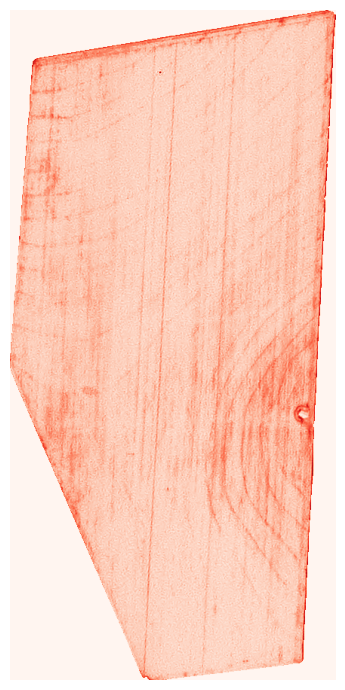

In [49]:
redn[band_mask] = np.nan
plot_raster_band(redn, cmap='Reds')


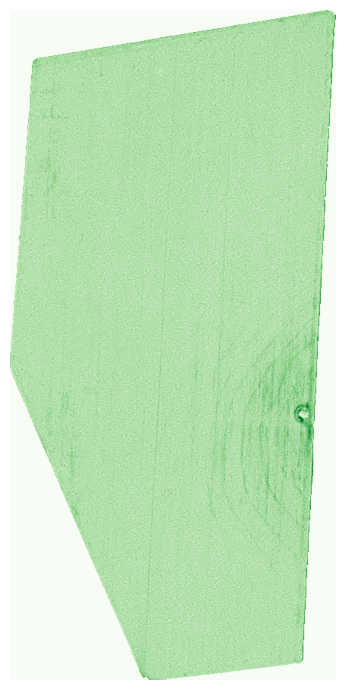

In [50]:
greenn[band_mask] = np.nan
plot_raster_band(greenn, cmap='Greens')


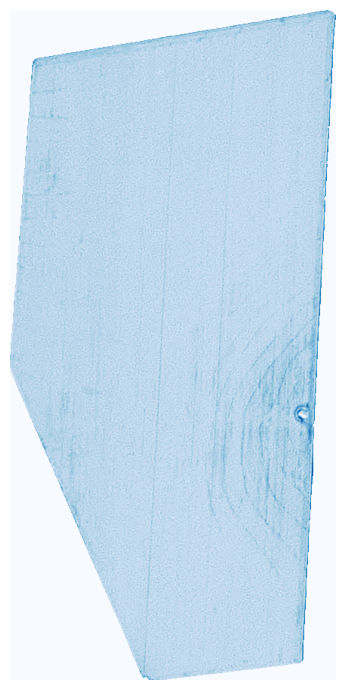

In [51]:
bluen[band_mask] = np.nan
plot_raster_band(bluen, cmap='Blues')

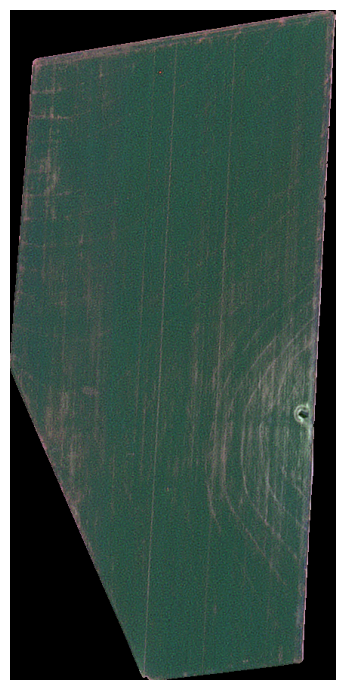

In [52]:
# Create RGB natural color composite
rgb = np.dstack((redn, greenn, bluen))
plot_raster_band(rgb, cmap=None)

### Como remover o fundo da imagem

In [53]:
def remove_blue_background(buf: io.BytesIO, local_rgb_path: str) -> None:
    buf.seek(0)
    img = Image.open(buf)
    rgba = img.convert("RGBA")
    datas = rgba.getdata()

    newData = []

    for item in datas:
        if item[0] == 0 and item[1] == 0 and item[2] == 255:  # finding yellow colour
            # replacing it with a transparent value
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
    rgba.putdata(newData)
    rgba.save(local_rgb_path, format='PNG')
    display(rgba)

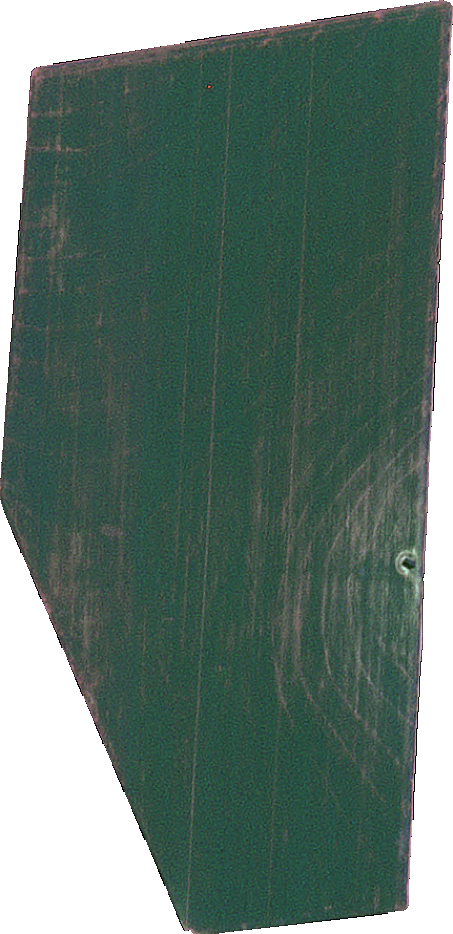

In [55]:
cmap = ListedColormap(['#0000FF'])
px = 1024
fig, ax = plt.subplots(
    figsize=(px / 300, px / 300), dpi=300)
ax.axis('off')
masked = np.ma.masked_where(np.nan_to_num(
    red, nan=0) != 0, np.nan_to_num(red, nan=0))
ax.imshow(rgb, extent=bounds_extent)
ax.imshow(masked, alpha=1, cmap=cmap, extent=bounds_extent)
ax.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
plt.tight_layout()
buf = io.BytesIO()
plt.savefig(buf, transparent=True,
            bbox_inches='tight',
            pad_inches=0,
            format='png',
            dpi=300)
plt.close()
remove_blue_background(buf = buf, local_rgb_path='data/outputs/rgb.png')

### Criando índices

In [42]:
raster_path = 'data/original.tif'

raster = rasterio.open(raster_path)
bands = {'red':6, 'blue':2, 'green':4, 'nir':8, 'costal_blue':1, 'green_I':3,'yellow':5, 'red_edge':7}

In [38]:
raster_path = 'data/original.tif'

raster = rasterio.open(raster_path)
b = raster.bounds
bounds_extent = np.asarray([b.left, b.right, b.bottom, b.top])
bands = {'red':6, 'blue':2, 'green':4, 'nir':8, 'costal_blue':1, 'green_I':3,'yellow':5, 'red_edge':7}

# Convert to floats
red = raster.read(bands.get('red')).astype('f4')
nir = raster.read(bands.get('nir')).astype('f4')
red_edge =raster.read(bands.get('red_edge')).astype('f4')

np.seterr(divide='ignore', invalid='ignore')

# Calculate NDVI using numpy arrays
ndvi = (nir - red) / (nir + red)
ndre = (nir - red_edge)/(nir+red_edge)

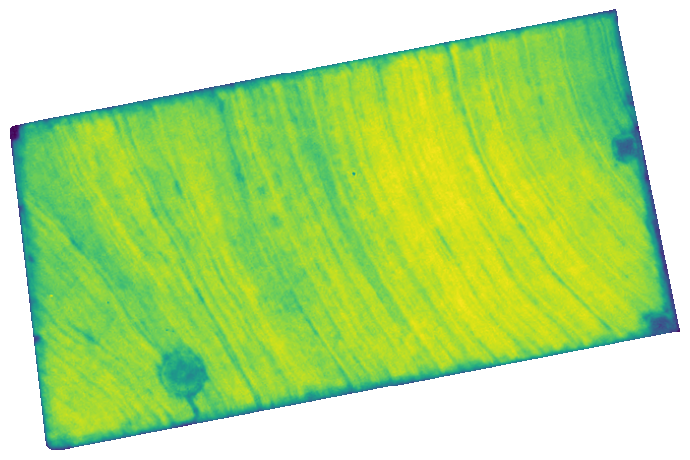

In [39]:
plot_raster_band(band=ndvi, cmap=None)

# Trabalhando com shape files

### Abrindo os arquivos

In [66]:
gdf_itamarati = gpd.read_file('data/itamarati_shapefie/Itamarati.shp')
gdf_precipitation = gpd.read_file('data/precipitacao_shapefile/Precipitacao_2012.shp')

### Verificando as projeções

Ao trabalhar com dados geoespaciais fique atento aos seus atributos, especialmente projeção. Se deseja combinar informações certifique-se que estão na mesma projeção.

In [67]:
gdf_precipitation.crs

<Derived Projected CRS: EPSG:31981>
Name: SIRGAS 2000 / UTM zone 21S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - between 60°W and 54°W, northern and southern hemispheres. In remainder of South America - between 60°W and 54°W, southern hemisphere, onshore and offshore.
- bounds: (-60.0, -44.82, -54.0, 4.51)
Coordinate Operation:
- name: UTM zone 21S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [68]:
gdf_itamarati.crs

<Derived Projected CRS: PROJCS["unknown",GEOGCS["GCS_unknown",DATUM["D_Unk ...>
Name: unknown
Axis Info [cartesian]:
- [east]: Easting (kilometre)
- [north]: Northing (kilometre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: D_Unknown_based_on_GRS80_ellipsoid_using_towgs84_0_0_0_0_0_0_0
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [71]:
gdf_itamarati.to_crs(gdf_precipitation.crs, inplace=True)

### Visualizando o mapa

In [69]:
def plot_map_fazenda(df_base: gpd.GeoDataFrame, df_aditional_info: gpd.GeoDataFrame, title: str):
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    base_map = df_base.plot(color='blue', edgecolor='black', ax = ax)
    precipitation = df_aditional_info.plot(ax=base_map, color='red', alpha= 1)
    fig.suptitle(title, fontsize=15, fontweight="bold")
    plt.xlabel(' ', fontsize=12)
    plt.ylabel(' ', fontsize=12)

    # # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)

    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)

    # # Add x, y gridlines
    ax.grid(b = True, color ='darkgrey',
            linestyle ='-.', linewidth = 0.7,
            alpha = 0.2)

    # # Show top values
    ax.invert_yaxis()
    
    plt.show()

/var/folders/nt/fg9d73ps0n1ffhx0m4nxj5lh0000gn/T/ipykernel_22033/3974784013.py:22: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='darkgrey',


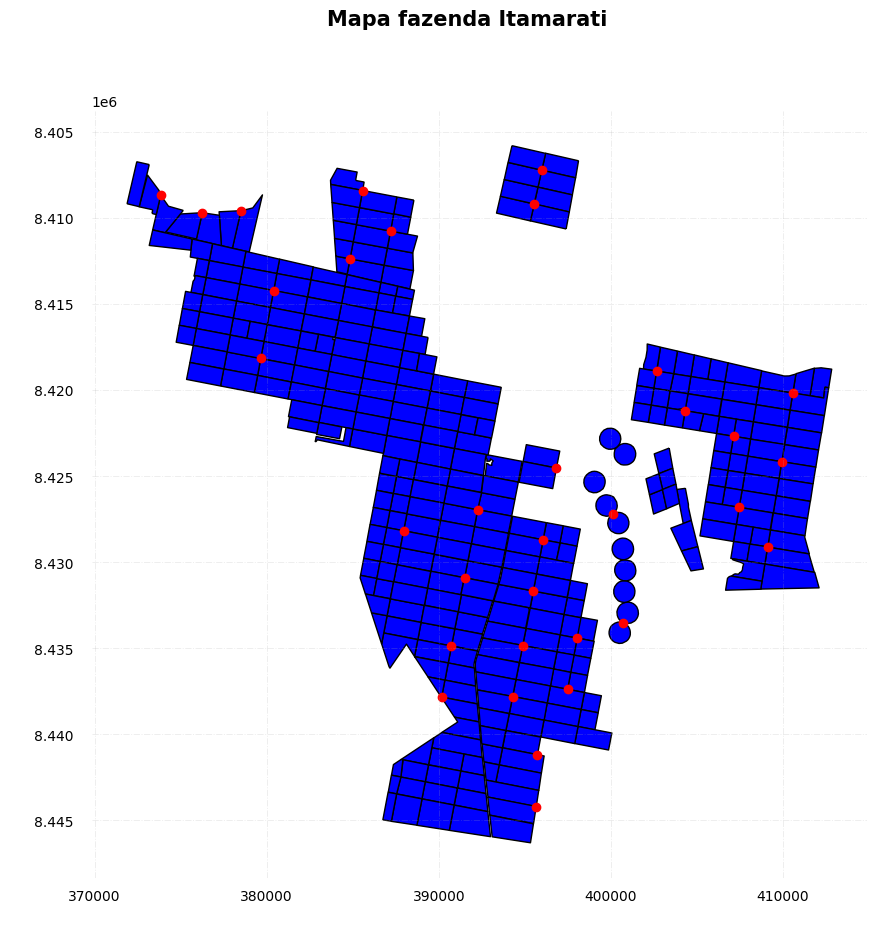

In [72]:

plot_map_fazenda(df_base=gdf_itamarati, df_aditional_info=gdf_precipitation, title="Mapa fazenda Itamarati")


/var/folders/nt/fg9d73ps0n1ffhx0m4nxj5lh0000gn/T/ipykernel_22033/3974784013.py:22: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='darkgrey',


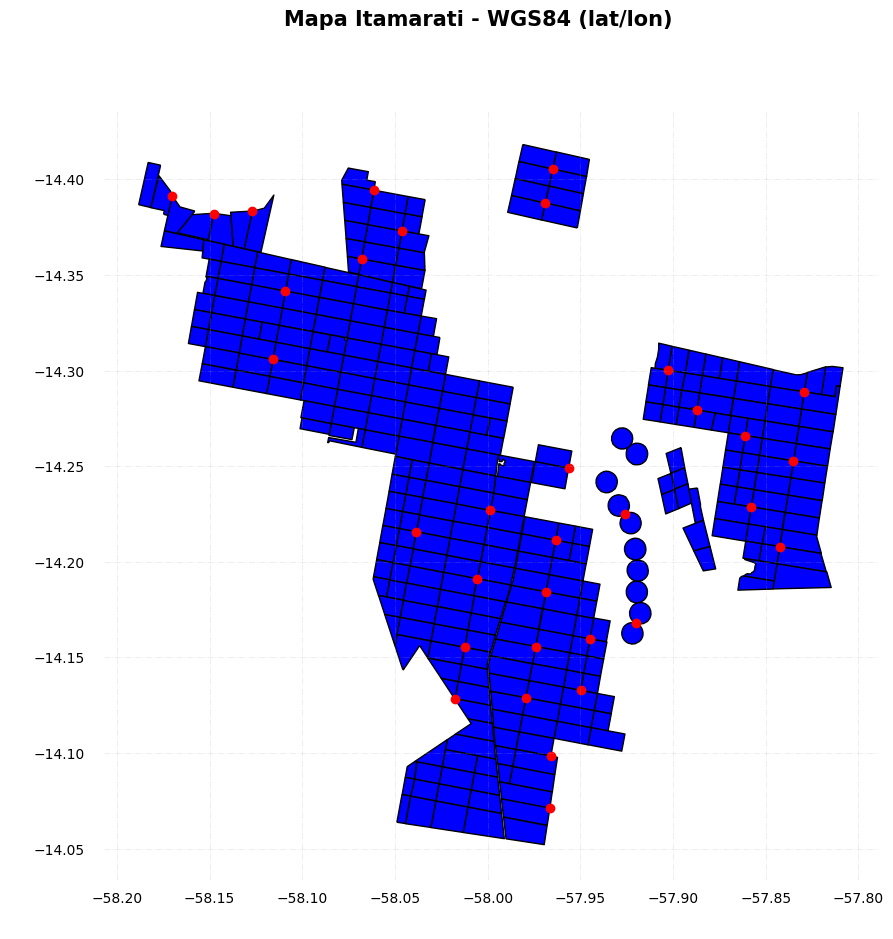

In [73]:
gdf_precipitation.to_crs('EPSG:4326', inplace=True)
gdf_itamarati.to_crs('EPSG:4326', inplace=True)
plot_map_fazenda(df_base=gdf_itamarati, df_aditional_info=gdf_precipitation, title='Mapa Itamarati - WGS84 (lat/lon)')

### Interpolando dados

In [74]:
gdf_itamarati.head()

,Fazenda,Setor,Talhao,geometry
0,Itamarati,Brasflor,1,"POLYGON ((-57.94511 -14.41049, -57.96285 -14.4..."
1,Itamarati,Brasflor,2,"POLYGON ((-57.94835 -14.39253, -57.94664 -14.4..."
2,Itamarati,Brasflor,3,"POLYGON ((-57.96883 -14.38766, -57.94996 -14.3..."
3,Itamarati,Brasflor,4,"POLYGON ((-57.95162 -14.37463, -57.94995 -14.3..."
4,Itamarati,Brasflor,5,"POLYGON ((-57.96887 -14.38762, -57.98710 -14.3..."


In [76]:
gdf_precipitation.head()

,codigo_est,soma,y,x,Coord_X,Coord_y,Talhao,geometry
0,1,2162.0,-14.456389,-58.097222,395983.0,8407209.0,1.0,POINT (-57.96488 -14.40550)
1,2,1710.0,-14.426944,-57.985556,395544.0,8409172.0,3.0,POINT (-57.96887 -14.38773)
2,3,1598.0,-14.432222,-58.164444,384842.0,8412362.0,15.0,POINT (-58.06799 -14.35847)
3,4,2179.0,-14.435278,-58.079167,387192.0,8410748.0,17.0,POINT (-58.04627 -14.37316)
4,5,2096.0,-14.386389,-58.217778,385571.0,8408396.0,24.0,POINT (-58.06140 -14.39435)


Observe que nosso objetivo é interpolar os pontos de `gdf_precipitation` e criar uma matriz de ordem $n x n$ onde as cordenadas &x_i& e $y_j$ deveram ser tais que $x_{min} < x_i <x_{max}$ e $y_{min} < y_i <y_{max}$ sendo  $x_{min}$ o menor valor da coordenada x em `gdf_itamarati`,  $x_{max}$ o maior valor de x em `gdf_itamarati`, $y_{min}$ o menor valor da coordenada y e  $y_{max}$ o maior valor de x em `gdf_itamarati`. Após obter a matriz, iremos salvá-la como um arquivo raster, e usar o rasaterio para filtrar deste raster apenas os valores que estão dentro dos talhões da fazenda. 

Iremos seguir os seguintes passos:

1. definir $x_{min}, x_{max}, y_{min}, y_{max}$.
2. criar um array `1D` contendo n pontos igualmente espaçados entre $x_{min}$ e $x_{max}$
3. criar um array `1D` contendo n pontos igualmente espaçados entre $y_{min}$ e $y_{max}$
4. realizar a interpolação. Ppara isso usaremos como argumentos de entrada, as coordenadas x e y de `gdf_precipitation` e os valores de mm de chuva acumulados. A interpolação será feita considerando um grid construído a partir dos vetores criados nos passos 2 e 3. Obteremos então um array $Z_{nxn}$ contendo os valores estimados para os ponto $P_i = (x_i, y_i)$.
5. Salvar o array interpolado (Z) em um raster.
6. Ler o raster com rasterio.
7. usar a função mask do rasterio para mascarar do nosso raster contendo os valores interpolados, valores fora da região da fazenda. Usaremos um array contendo a coluna `geometry` de `gdf_itamarati`.

Steps 1, 2 and 3

In [153]:
# 1: define xmax, ymax, xmin and y min
min_x, min_y, max_x, max_y = gdf_itamarati.total_bounds
# 2 and 3: Horizontal and vertical cell counts should be the same
n_points = 1000
xx_grid_coord = np.linspace(min_x, max_x, n_points)
yy_grid_coord = np.linspace(min_y, max_y, n_points)

Step 4: Interpolation

In [156]:
# 4: Interpolation
x_rain = gdf_precipitation["geometry"].x
y_rain = gdf_precipitation["geometry"].y
values_rain = list(gdf_precipitation.soma)
# Generate ordinary kriging object
OK = OrdinaryKriging(
    np.array(x_rain),
    np.array(y_rain),
    values_rain,
    variogram_model = "linear",
    verbose = False,
    enable_plotting = False,
    coordinates_type = "euclidean",
)

# execute the interpolation process using the method execute of our object.
interpolated_values, sigma_squared_p_krig = OK.execute("grid", xx_grid_coord, yy_grid_coord)

Step 5. Save interpolated array (Z) as a raster file.

In [157]:
# method to save an array as a raster file
def export_kde_raster(interpoolated_values: np.array, x_coord: np.array, y_coord: np.array, min_x, max_x, min_y, max_y, proj, filename: str):
    '''Export and save a kernel density raster.'''

    # Get resolution
    xres = (max_x - min_x) / len(x_coord)
    yres = (max_y - min_y) / len(y_coord)

    # Set transform
    transform = Affine.translation(min_x - xres / 2, min_y - yres / 2) * Affine.scale(xres, yres)

    # Export array as raster
    with rasterio.open(
            filename,
            mode = "w",
            driver = "GTiff",
            height = interpoolated_values.shape[0],
            width = interpoolated_values.shape[1],
            count = 1,
            dtype = interpoolated_values.dtype,
            crs = proj,
            transform = transform,
    ) as new_dataset:
            new_dataset.write(interpoolated_values, 1)

In [159]:
# Export raster
file_path = "data/outputs/precipitation_interpolated..tif"
export_kde_raster(interpoolated_values=interpolated_values, x_coord=xx_grid_coord, y_coord=yy_grid_coord,
min_x = min_x, max_x = max_x, min_y = min_y, max_y = max_y,
                  proj = gdf_precipitation.crs, 
                  filename = file_path)

Step 6. Read the file created using rasterio.

In [171]:
# Open raster
raster_interpolated = rasterio.open(file_path)

In [172]:
# Create copy of test dataset
gdf_precipitation_copy = gdf_precipitation.copy()


Extra Step: You can go to next step if you want. 

In [173]:
# Subset the GeoDataFrame by checking which test points are within the raster extent polygon
# If a test point is beyond the extent of training points dataset, the kriging output may not cover that test point
# Create polygon with extent of raster
raster_interpolated_extent = box(*raster_interpolated.bounds)
# Convert shapely object to a GeoDataFrame
gdf_raster_interpolated_extent = gpd.GeoDataFrame({'Attribute': ['name1'], 'geometry': raster_interpolated_extent}, geometry = 'geometry', crs = gdf_precipitation.crs)
# Create a mask
mask_is_in_extent_polygon = gdf_precipitation_copy.within(gdf_raster_interpolated_extent.geometry.values[0])
# # Remove from gdf_precipitaiton values out of the raster_interpolated_extent
gdf_precipitation_copy = gdf_precipitation_copy[mask_is_in_extent_polygon]


In [176]:
# Create list of XY coordinate pairs for the test points that fall within raster extent polygon
points_to_be_tested = [[x, y] for x,y in zip(gdf_precipitation_copy["geometry"].x, gdf_precipitation_copy["geometry"].y)]

In [177]:
raster_interpolated.read(1).shape

(1000, 1000)

In [178]:
# Extract raster value at each test point and add the values to the GeoDataFrame
gdf_precipitation_copy["predict_values"] = [x[0] for x in raster_interpolated.sample(points_to_be_tested)]

In [179]:
# Generate out-of-sample R^2
out_r_squared_tp = r2_score(gdf_precipitation_copy.soma, gdf_precipitation_copy.predict_values)
print("PyKrige Kriging out-of-sample r-squared: {}".format(round(out_r_squared_tp, 2)))

# Display attribute table
print("\nAttribute Table: Random Points Interpolated Values - PyKrige Kriging Method")
display(gdf_precipitation_copy.head(2))


PyKrige Kriging out-of-sample r-squared: 0.2

Attribute Table: Random Points Interpolated Values - PyKrige Kriging Method


,codigo_est,soma,y,x,Coord_X,Coord_y,Talhao,geometry,predict_values
0,1,2162.0,-14.456389,-58.097222,395983.0,8407209.0,1.0,POINT (-57.96488 -14.40550),1853.008454
1,2,1710.0,-14.426944,-57.985556,395544.0,8409172.0,3.0,POINT (-57.96887 -14.38773),1841.852195


Step 7: Masking the raster using `rasterio.mask.mask`

In [185]:
# Mask raster to counties shape
band_interpolated_masked, affine_transform_masked_raster_interpolated = mask(raster_interpolated, gdf_itamarati.geometry.values, crop = True)

In [186]:
band_interpolated_masked

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [184]:
affine_transform_masked_raster_interpolated

Affine(0.00037999665246999113, 0.0, -58.18843834721055,
       0.0, 0.00036610167162121776, -14.418393132563702)

/var/folders/nt/fg9d73ps0n1ffhx0m4nxj5lh0000gn/T/ipykernel_22033/105788843.py:31: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='darkgrey',


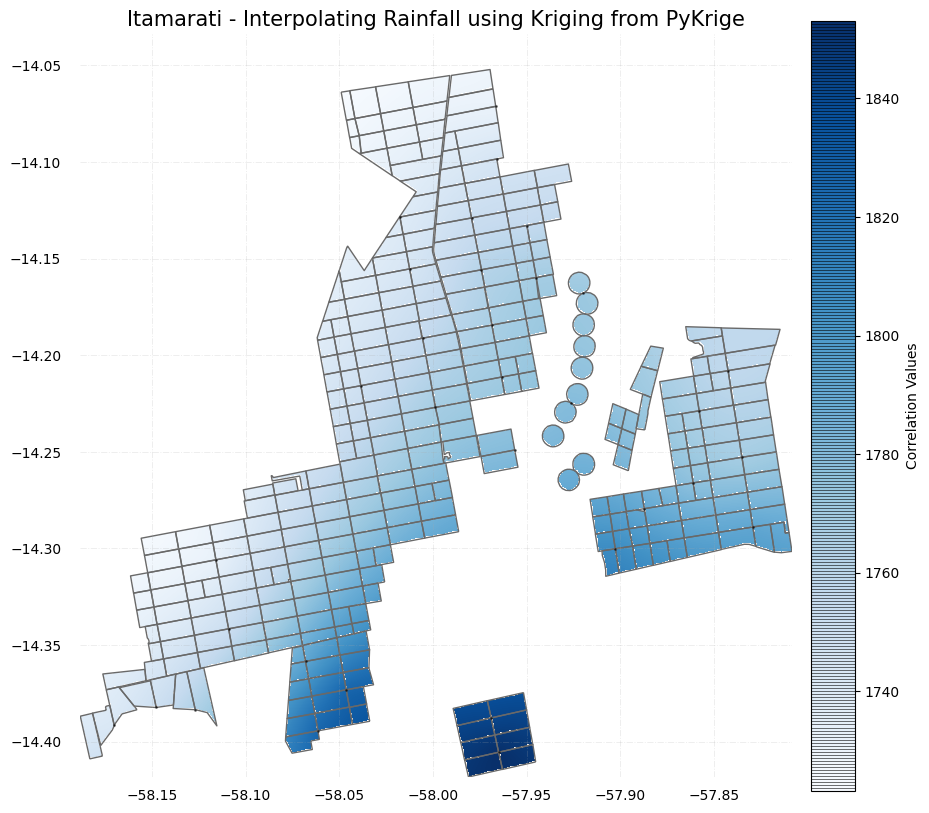

In [187]:
b = raster_interpolated.bounds
bounds_extent = np.asarray([b.left, b.right, b.bottom, b.top])
array_values = band_interpolated_masked.reshape(1000, 1000)
array_values = array_values.astype('float')
array_values[array_values == 0] = np.nan
# Plot data
fig, (ax, cbar_ax) = plt.subplots(1,2, figsize=(10,10), gridspec_kw={'wspace':0.05, 'width_ratios':(0.8,0.05)} )
cbar_kws={"label":"Correlation Values","orientation":"vertical",
#  "ticks":[-1, -0.5,0, 0.5, 1], 
 "extendfrac":100, "drawedges":True }

precipitation_map = ax.imshow(array_values, cmap = "Blues", extent=bounds_extent)
ax.plot(x_rain, y_rain, 'k.', markersize = 2, alpha = 0.5)
gdf_itamarati.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
# plt.gca().invert_yaxis()
plt.colorbar(precipitation_map, cax=cbar_ax, **cbar_kws)

# # Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# # Add x, y gridlines
ax.grid(b = True, color ='darkgrey',
        linestyle ='-.', linewidth = 0.7,
        alpha = 0.2)

# # Show top values
ax.invert_yaxis()

# Set title
ax.set_title('Itamarati - Interpolating Rainfall using Kriging from PyKrige', fontdict = {'fontsize': '15', 'fontweight' : '3'})

# Display plot
plt.show()

# Tutoriais online

https://pygis.io/docs/a_intro.html

https://automating-gis-processes.github.io/CSC/notebooks/L5/raster-map-algebra.html